In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from shallow.torch.flows import CouplingNeuralSplineFlow, trainer
from shallow.torch.utils import count_parameters

In [2]:
def make_data(n_hyper, n_samples):

    shifts = np.random.uniform(-10, 10, (n_hyper, 1))
    scales = np.random.uniform(0, 10, (n_hyper, 1))
    x = np.random.randn(1, n_samples) * scales + shifts

    shifts = np.repeat(shifts, n_samples, axis=1)
    scales = np.repeat(scales, n_samples, axis=1)

    return x, shifts, scales

In [3]:
x, shifts, scales = make_data(100, 1_000)
x.shape, shifts.shape, scales.shape

((100, 1000), (100, 1000), (100, 1000))

In [4]:
x = np.concatenate(x)[:, None]
shifts = np.concatenate(shifts)[:, None]
scales = np.concatenate(scales)[:, None]
c = np.concatenate([shifts, scales], axis=1)

In [5]:
x.shape, c.shape

((100000, 1), (100000, 2))

In [6]:
dim = x.shape[1]
cond_dim = c.shape[1]

In [7]:
x = torch.as_tensor(x)
c = torch.as_tensor(c)

In [8]:
flow = CouplingNeuralSplineFlow(
    inputs=dim, # Number of parameter dimensions
    contexts=cond_dim, # Number of conditional dimensions
    bounds=None, # Parameter boundaries
    norm_inputs=False, # Standardize parameters, bool or array/tensor
    norm_contexts=False, # Standardize contexts, bool or array/tensor
    transforms=2, # Number of flow layers
    residual=False, # MLP (False) or residual network (True)
    blocks=1, # Number of blocks/layers in the net
    hidden=10, # Number of hidden units in each block/layer of the net
    activation='elu', # Activation function
    dropout=0.0, # Dropout probability for hidden units, 0 <= dropout < 1
    batchnorm_within=False, # Batch normalization within the net
    batchnorm_between=True, # Batch normalization between flow layers
    permutation=None, # None, 'random', 'reverse', or list
    linear=None, # None or 'lu'
    embedding=None, # Network to embed contexts
    distribution=None, # None (standard normal) or nflows Distribution
    mask='mid',
    bins=5,
    tails='linear',
    bound=5.0,
    )

In [9]:
count_parameters(flow)

652

In [10]:
flow, losses = trainer(
    flow,
    x,
    contexts=c,
    learning_rate=1e-3,
    epochs=1_000,
    batch_size=1_000,
    stop=10,
    verbose=True,
    )

  5%|███▎                                                         | 54/1000 [01:06<19:32,  1.24s/it]

No improvement for 10 epochs, stopping


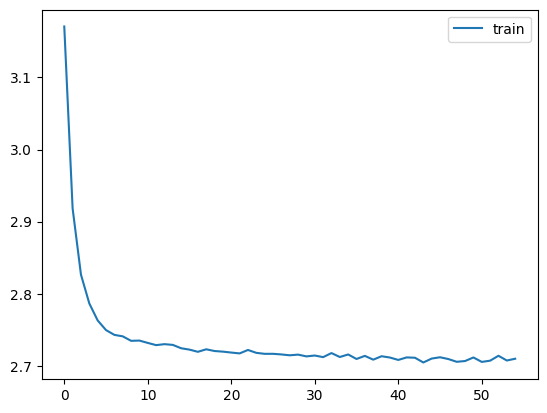

In [11]:
for label, loss in losses.items():
    plt.plot(loss, label=label)
plt.legend();

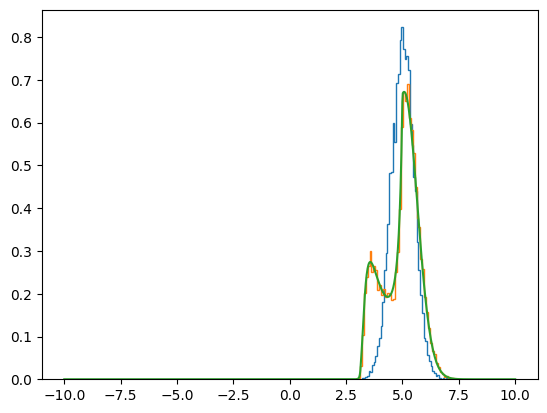

In [12]:
shift = 5
scale = 0.5

plt.hist(np.random.normal(shift, scale, 10_000), bins=50, density=True, histtype='step')

xx = np.linspace(-10, 10, 1_000)
# cc = np.repeat(np.array([shift, scale])[None, :], xx.size, axis=0)
cc = torch.as_tensor([shift, scale], dtype=torch.float32)[None, :]

with torch.inference_mode():
    z = flow.sample(10_000, cc).numpy().squeeze()
    p = np.exp(flow.log_prob(
        torch.as_tensor(xx[:, None], dtype=torch.float32),
        cc.repeat(xx.size, 1),
        ).numpy())
plt.hist(z, bins=50, density=True, histtype='step');
plt.plot(xx, p);